In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
from dask.diagnostics import ProgressBar
from functools import partial
import dask


#fft packages
from scipy import fftpack
import math
from scipy import fft
from scipy import ndimage
from scipy import signal

In [2]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 18)  # controls default text layout
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

#sns.set()
#plt.minorticks_on()

plt.rc('text', usetex=False)


In [3]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [4]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num)
            #IOP03
            if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num)         
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)




In [5]:
def calc_u_star(ds,w_level):
    #above canopy momentum fluxes
    w_av = ds.w.sel(zw_3d=w_level)#[1:]

    uw_av = ds.uw.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'xu': 'x'}).interp_like(ds.v)
    u_av = ds.u.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'xu': 'x'}).interp_like(ds.v)#[1:]
    uprime_wprime = (uw_av - u_av*w_av)

    vw_av = ds.vw.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'yv': 'y'}).interp_like(ds.u)#[1:]#[1:]
    v_av = ds.v.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'yv': 'y'}).interp_like(ds.u)#[1:]
    vprime_wprime = (vw_av - v_av*w_av)

    time_stamp =  (uw_av['time'].dt.strftime('%H:%M'))

    #above canopy u*
    u_star = (uprime_wprime**2 + vprime_wprime**2)**(0.25)
    
    return u_star

def u_star_list(ds,time_array):
    
    u_star_list = []
    
    for time_step in time_array:
        u_star_val = calc_u_star(ds.sel(zw_3d = slice (0,60),zu_3d = slice (0,60),time=time_step),36).mean().compute().values
        u_star_list.append(u_star_val)
    return u_star_list

In [6]:
def belltaper(var, n): #-- following Stull 1999
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    out = var * W
    return(out)

def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))

    return psd1D

In [7]:
member_list = np.arange(1,9)

# ensemble_ds_iop02_P_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDFslice','iop02')
# ensemble_ds_iop02_P = xr.concat(ensemble_ds_iop02_P_list,dim='ensemble')

ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.44901930820196867 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2752658976241946 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.27499758545309305 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  1.53

In [8]:
member_list = np.arange(0,8)

ensemble_ds_iop03_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02 = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  3.715410266071558 seconds
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
Done with member 1  Time elapsed  2.8901396095752716 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3660314

Calculate length scales from the surface buoyancy fluxes. for now do the vertically integrated surface+PCM fluxes. normalize it by the domain mean flux. 

##### Plot length/zi for Aug23 and see

In [8]:
ensemble_member_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
profile_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
ensemble_member_surf_ds_2 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.32686370704323053 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.1247487282380462 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  3.1084376918151975 seconds


In [13]:
#subset it for the 10x10 smaller domain 
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168

#ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))
ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_iop02 = ensemble_member_ds_2_N02_iop02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_surf_iop02 = ensemble_member_surf_ds_2.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

def adjust_axis(ds):    
    ds['x'] = ds.x - ds.x[0]
    ds['y'] = ds.y - ds.y[0]
    ds['xu'] = ds.xu - ds.xu[0]
    ds['yv'] = ds.yv - ds.yv[0]
    
    
    return (ds)

ds_het_iop02 = adjust_axis(ds_het_iop02)
ds_2_het_iop02 = adjust_axis(ds_2_het_iop02)
ds_2_het_surf_iop02 = adjust_axis(ds_2_het_surf_iop02)




Rerun this next time for final plots:

In [9]:
zi_theta_av_list = []
IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:00.000000000')).values
vertical_slice = [600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta_v = ds_2_het_iop02.theta.sel(time = time_step)*(1 + 0.61*ds_2_het_iop02.q.sel(time = time_step))
    zi_xy_av = (theta_v.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02 = xr.concat(zi_theta_av_list,'time')

[########################################] | 100% Completed | 507.06 ms
[########################################] | 100% Completed | 504.84 ms
[########################################] | 100% Completed | 605.98 ms
[########################################] | 100% Completed | 605.13 ms
[########################################] | 100% Completed | 605.79 ms
[########################################] | 100% Completed | 605.20 ms
[########################################] | 100% Completed | 705.93 ms
[########################################] | 100% Completed | 706.38 ms
[########################################] | 100% Completed | 706.37 ms
[########################################] | 100% Completed | 706.28 ms
[########################################] | 100% Completed | 706.61 ms
[########################################] | 100% Completed | 705.97 ms
[########################################] | 100% Completed | 706.04 ms
[########################################] | 100% Completed | 70

In [10]:
zi_theta_iop02

<xarray.DataArray 'zu_3d' (time: 15)>
array([ 127.17374916,  186.31875251,  396.70267766,  489.81241256,
        774.62413901, 1191.6998708 , 1237.6693072 , 1401.17308978,
       1551.37994208, 1531.30430831, 1598.47618623, 1612.84239697,
       1616.62775674, 1625.69333036, 1626.38023613])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T09:00:00 ... 2019-08-23T16:00:00

In [9]:
IOP02_time_array = np.asarray(['2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000'], dtype='datetime64[ns]')

# w_star_list = [1.6306372,  1.87832223, 1.93912139, 2.09285816, 2.25351041, 2.23918977,
#  2.08612784, 2.08723152, 2.1083716,  2.03151429, 1.51969396]

# zi_iop02 = [ 128.4789129 ,  186.29704611,  402.40461573,  485.38067276,
#         906.50266875, 1256.90609044, 1255.68711072, 1428.77175317,
#        1573.09371352, 1556.12316329, 1609.16728002, 1625.39083092,
#        1628.12380486, 1633.47266652, 1634.52013366]
zi_iop02  =  [ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] 


##### Trial plots

In [11]:
H_PCM = (ds_2_het_iop02.pcm_heatrate.sel(time='2019-08-23T12:00:00.000000000').sum('zpc_3d')*1.17*1005*12)
LE_PCM = (ds_2_het_iop02.pcm_latentrate.sel(time='2019-08-23T12:00:00.000000000').sum('zpc_3d')*1.17*1005*12)

H_surf = ds_2_het_surf_iop02['shf*_xy'].sel(time='2019-08-23T12:00:00.000000000')
LE_surf = ds_2_het_surf_iop02['qsws*_xy'].sel(time='2019-08-23T12:00:00.000000000')



[########################################] | 100% Completed | 101.67 ms
[########################################] | 100% Completed | 101.40 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 101.50 ms


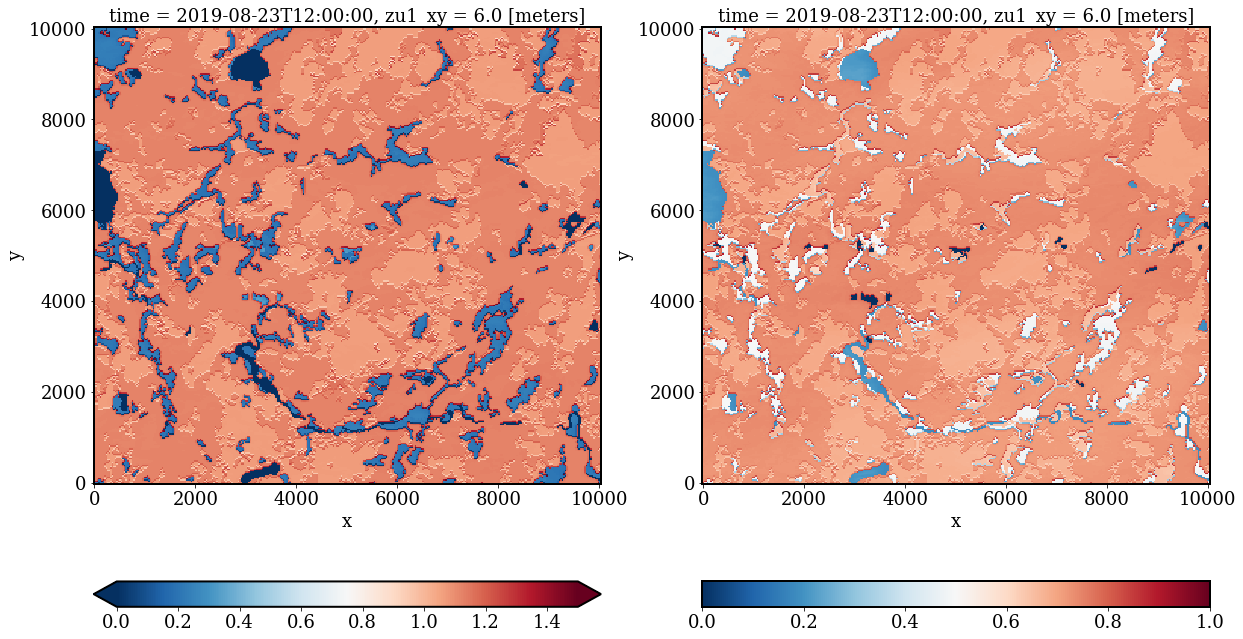

In [12]:
domain_mean_LE = (LE_surf + LE_PCM).mean('x').mean('y').compute()
domain_mean_H = (H_surf + H_PCM).mean('x').mean('y').compute()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))

((H_surf + H_PCM)/domain_mean_H).plot(ax=ax1,cmap='RdBu_r', vmin=0,vmax = 1.5,cbar_kwargs={'location':'bottom'})

((LE_surf + LE_PCM)/domain_mean_H).plot(ax=ax2,cmap='RdBu_r',vmin=0,vmax = 1,cbar_kwargs={'location':'bottom'})



##### Working code

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.43645508401095867 seconds
[########################################] | 100% Completed | 208.29 ms


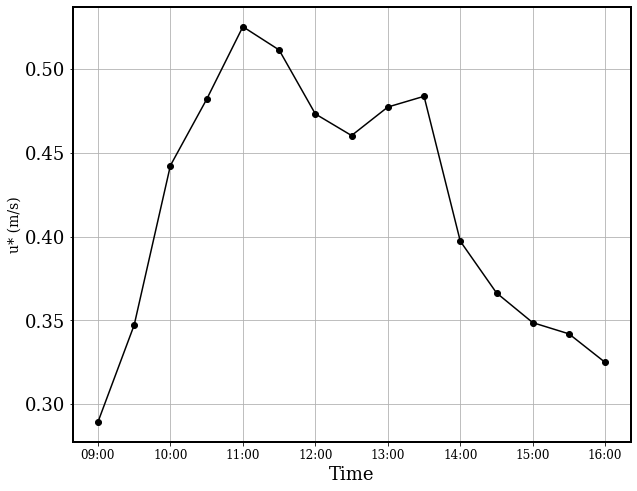

In [29]:
#ustar calculations with full domain  mean values

#IOP02
profile_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02').sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:01.200000000')).resample(time='30T').mean()

#IOP03
#profile_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03').sel(time=slice('2019-09-24T10:00:01.200000000','2019-09-24T14:00:01.200000000')).resample(time='30T').mean()

#above canopy momentum fluxes
w_av = profile_N02_member_2_ds.w.sel(zw=36)#[1:]

wu_av = profile_N02_member_2_ds.wu.sel(zwu=36)#[1:]
u_av = profile_N02_member_2_ds.u.rename({'zu': 'zw'}).interp_like(profile_N02_member_2_ds.w).sel(zw=36)#[1:]
uprime_wprime = wu_av - w_av*u_av

wv_av = profile_N02_member_2_ds.wv.sel(zwv=36)#[1:]
v_av = profile_N02_member_2_ds.v.rename({'zv': 'zw'}).interp_like(profile_N02_member_2_ds.w).sel(zw=36)#[1:]
vprime_wprime = wv_av - w_av*v_av

time_stamp =  (wu_av['time'].dt.strftime('%H:%M'))

#above canopy u*
u_star = (uprime_wprime**2 + vprime_wprime**2)**(0.25)

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,u_star,'-o',color='black')
#ax1.axvline(x='13:00')
ax1.set_ylabel('u* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)


In [16]:
u_star_list_iop02_2 = u_star_list(ds_2_het_iop02,IOP02_time_array)


[########################################] | 100% Completed | 102.18 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 102.20 ms
[########################################] | 100% Completed | 102.17 ms
[########################################] | 100% Completed | 102.20 ms
[########################################] | 100% Completed | 102.15 ms
[########################################] | 100% Completed | 102.12 ms
[########################################] | 100% Completed | 102.12 ms
[########################################] | 100% Completed | 102.10 ms
[########################################] | 100% Completed | 102.22 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 10

[array(0.2461864, dtype=float32),
 array(0.2744869, dtype=float32),
 array(nan, dtype=float32),
 array(0.39817616, dtype=float32),
 array(0.42797342, dtype=float32),
 array(0.4454284, dtype=float32),
 array(0.41556457, dtype=float32),
 array(0.41464233, dtype=float32),
 array(0.41703707, dtype=float32),
 array(0.43543258, dtype=float32),
 array(0.40890935, dtype=float32),
 array(0.3643331, dtype=float32),
 array(0.37420803, dtype=float32),
 array(0.3747994, dtype=float32),
 array(nan, dtype=float32)]

Comparisons between full-domain(N02) mean and subset(10x10 km2) mean u*

In [13]:
rows, cols = (8,15 )
u_star_list_iop02 = [[0]*cols]*rows

for member in np.arange(1,9):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:01.200000000'))
    ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
    u_star_list_iop02[member-1] = u_star_list(ds,IOP02_time_array)


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.37469951808452606 seconds
[########################################] | 100% Completed | 102.33 ms
[########################################] | 100% Completed | 102.20 ms
[########################################] | 100% Completed | 102.08 ms
[########################################] | 100% Completed | 102.09 ms
[########################################] | 100% Completed | 102.12 ms
[########################################] | 100% Completed | 102.49 ms
[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 102.15 ms
[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 102.17 ms
[######

[########################################] | 100% Completed | 207.43 ms


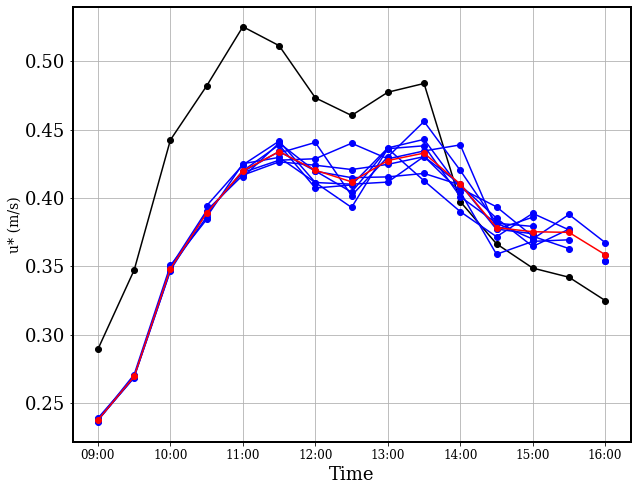

In [92]:

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,u_star,'-o',color='black')
for i in np.arange(0,8):
    ax1.plot(time_stamp,u_star_list_iop02[i],'-o',color='blue')
ax1.plot(time_stamp,np.nanmean(u_star_list_iop02,0),'-o',color='red')


#ax1.axvline(x='13:00')
ax1.set_ylabel('u* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

I'll use the mean values from the ensemble runs..

In [16]:
u_star_array_iop02 = np.nanmean(u_star_list_iop02,0)
u_star_array_iop02

array([0.23746523, 0.26933923, 0.34820446, 0.3888348 , 0.41974205,
       0.4338308 , 0.42021513, 0.41170758, 0.427308  , 0.4327292 ,
       0.41003117, 0.37822667, 0.37520644, 0.37473503, 0.35841644],
      dtype=float32)

In [24]:
u_star_array_iop02 = np.asarray([0.23746523, 0.26933923, 0.34820446, 0.3888348 , 0.41974205,
       0.4338308 , 0.42021513, 0.41170758, 0.427308  , 0.4327292 ,
       0.41003117, 0.37822667, 0.37520644, 0.37473503, 0.35841644],
      dtype='float32')

In [38]:
time_list = ensemble_member_ds_2_N02_iop02.time.sel(time=IOP02_time_array)

surface_T_list = []
surface_q_list = []
surface_Tv_list = []

for i, time_step in enumerate(time_list):

    #PCM fluxes in the domains

    N02_H_PCM = (ensemble_member_ds_2_N02_iop02.pcm_heatrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)

    N02_LE_PCM = (ensemble_member_ds_2_N02_iop02.pcm_latentrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)


    ###---------------------------------------------------
    #surface fluxes in the domains
    N02_H_surf = ensemble_member_surf_ds_2['shf*_xy'].sel(time=time_step)

    N02_LE_surf = ensemble_member_surf_ds_2['qsws*_xy'].sel(time=time_step)

    ###---------------------------------------------------
    
    N02_net_H_kinematic = (N02_H_surf+N02_H_PCM)/(1.17*1005)
    N02_net_LE_kinematic = (N02_LE_surf+N02_LE_PCM)/(1.17*2501*1000)
    theta = ensemble_member_ds_2_N02_iop02.sel(time=time_step).theta.sel(zu_3d = 30)
    N02_buoyancy_flux = N02_net_H_kinematic + theta*0.61*N02_net_LE_kinematic
    
    surface_T = N02_net_H_kinematic/u_star_array_iop02[i]
    surface_q = N02_net_LE_kinematic/u_star_array_iop02[i]
    surface_Tv = N02_buoyancy_flux/u_star_array_iop02[i] 

    # surface_T = N02_net_H_kinematic/w_star_array[i]
    # surface_q = N02_net_LE_kinematic/w_star_array[i]

    surface_T_list.append(surface_T)
    surface_q_list.append(surface_q)
    surface_Tv_list.append(surface_Tv)

surface_T_ds_iop02 =  xr.concat(surface_T_list,dim='time')
surface_q_ds_iop02 =  xr.concat(surface_q_list,dim='time')
surface_Tv_ds_iop02 =  xr.concat(surface_Tv_list,dim='time')


In [21]:
dataset = surface_T_ds_iop02
length_scale_list = []

for i, time_step in enumerate(dataset.time.values):
    
    T_surf = dataset.isel(time=i).values[0]
    x = dataset.isel(time=i).x.values
    y = dataset.isel(time=i).y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    # yloc = int(len(x)/2)
    # xloc = int(len(y)/2)
    # find 10 evenly spaced transects along each direction
    # ylocs = np.round(np.arange(5,Nx,Nx/10),0).astype(int)
    # xlocs = np.round(np.arange(5,Ny,Ny/10),0).astype(int)
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)


    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        Ty = T_surf[:,xloc]-T_surf[:,xloc].mean()
        Tx = T_surf[yloc,:]-T_surf[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        Tx_bt = belltaper(Tx,Nx)     
        Ty_bt = belltaper(Ty,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(Tx_bt)**2)[:int(Nx/2)])
        Sy = (np.abs(fftpack.fft(Ty_bt)**2)[:int(Ny/2)])           
        # extracting wavelength of spectrum maximum
        k_x_max = k_x[np.where(Sx == Sx.max())][0]
        k_y_max = k_y[np.where(Sy == Sy.max())][0]

        # determining l_x by simply converting 1/m to m
        lx.append(1/k_x_max)
        ly.append(1/k_y_max)
    l_x = np.mean(lx)
    l_y = np.mean(ly)   

    # heterogeneity scale is 1/2 l, average over x- and y-direction
    if (0.5*l_x + 0.5*l_y)/2 > 100000:
        length_scale_list.append(np.nan) # nan 
    else:
        length_scale_list.append((0.5*l_x + 0.5*l_y)*0.5) 

[########################################] | 100% Completed | 101.76 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 101.11 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.63 ms
[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 10

In [121]:
#T_length_scale_list = length_scale_list
q_length_scale_list = length_scale_list
#Tv_length_scale_list = length_scale_list

In [122]:
print(np.round(T_length_scale_list,2))
print(np.round(q_length_scale_list,2))
print(np.round(Tv_length_scale_list,2))

[1074.11 1096.28 1187.44 1321.5  1324.46 1320.26 1291.61 1298.5  1327.91
 1328.33 1326.18 1292.47 1314.82 1314.98 1310.84]
[1132.81 1063.33 1190.26 1526.97 1479.63 1462.47 1401.78 1495.66 1421.29
 1460.09 1341.56 1258.26 1359.46 1343.75 1364.16]
[1155.84 1071.56 1220.87 1536.15 1485.18 1472.74 1409.42 1498.39 1421.29
 1461.1  1341.13 1258.12 1342.93 1346.9  1355.78]


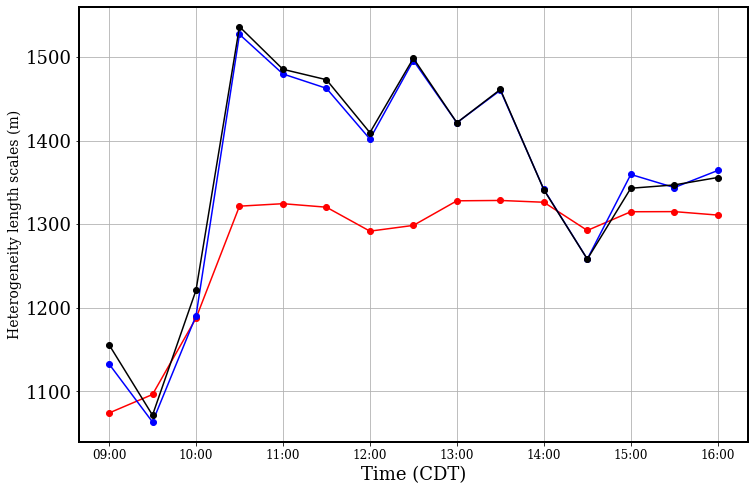

In [123]:
time_stamp =  (dataset['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_scale_iop02 = np.asarray(T_length_scale_list)
#print(T_length_scale)
# T_length_scale_iop02 = np.asarray([1187.44, 1321.5,  1324.46, 1320.26, 1291.61, 1298.5,  1327.91, 1328.33, 1326.18,
#                          1292.47, 1314.82, 1314.98, 1310.84, 1252.01, 1172.2,  1109.67, 1142.13])

q_length_scale_iop02 = np.asarray(q_length_scale_list)
#print(q_length_scale)
# q_length_scale_iop02 = np.asarray([1190.26, 1526.97, 1479.63, 1462.47, 1401.78, 1495.66, 1421.29, 1460.09, 1341.56,
#                          1258.26, 1359.46, 1343.75, 1364.16, 1265.9,  1088.61, 1075.21, 1058.07])

Tv_length_scale_iop02 = np.asarray(Tv_length_scale_list)
# Tv_length_scale_iop02 = np.asarray([1209.71, 1535.09, 1489.43, 1476.45, 1411.9,  1495.74, 1418.69, 1460.74, 1346.57,
#                          1260.03, 1343.87, 1344.41, 1354.62, 1263.58, 1091.1,  1083.56, 1058.45])


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_scale_iop02,'-o',color='red')
ax.plot(time_stamp,q_length_scale_iop02,'-o',color='blue')
ax.plot(time_stamp,Tv_length_scale_iop02,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Heterogeneity length scales (m)',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")


I want to calculate the cross-wind length scales :(

I need wind directions from 0900 to 1600

In [15]:
#for horizontal wind

u_data_list = []
v_data_list = []
time_array = IOP02_time_array

uwind_data = ds_2_het_iop02['u']
vwind_data = ds_2_het_iop02['v']

for i,sim_time in enumerate(time_array):
    
    #looping thrrough the time list
    #following line of code will concatenate all the data files of input_fname from member_num
    #and select the var at time sim_time
    u = uwind_data.sel(time=sim_time).mean('xu').mean('y').compute()
    v = vwind_data.sel(time=sim_time).mean('x').mean('yv').compute()
    #append the data to the list
    u_data_list.append(u)
    v_data_list.append(v)
    print('Done ', str(sim_time))

[########################################] | 100% Completed | 1.11 ss
[########################################] | 100% Completed | 1.01 sms
Done  2019-08-23T09:00:00.000000000
[########################################] | 100% Completed | 907.91 ms
[########################################] | 100% Completed | 1.01 sms
Done  2019-08-23T09:30:00.000000000
[########################################] | 100% Completed | 1.32 ss
[########################################] | 100% Completed | 1.21 ss
Done  2019-08-23T10:00:00.000000000
[########################################] | 100% Completed | 1.21 ss
[########################################] | 100% Completed | 1.11 ss
Done  2019-08-23T10:30:00.000000000
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 1.11 ss
Done  2019-08-23T11:00:00.000000000
[########################################] | 100% Completed | 1.01 sms
[########################################] |

In [16]:
mean_wind_dir_degrees_list = []
for i, time_step in enumerate(IOP02_time_array):
    tan_theta = (v_data_list[i].sel(zu_3d=slice(0,zi_iop02[i]))/u_data_list[i].sel(zu_3d=slice(0,zi_iop02[i]))).compute()
    mean_wind_dir_radians = np.arctan(tan_theta)
    mean_wind_dir_degrees = (mean_wind_dir_radians.mean()*180/np.pi).values
    mean_wind_dir_degrees_list.append(mean_wind_dir_degrees)

In [17]:
np.asarray(mean_wind_dir_degrees_list)

array([ 25.1624835 ,  18.75041802,   8.102142  ,   8.89602428,
        14.24730503,  16.02565065,  13.37958926,   6.69618812,
         2.57431922,   6.51778016,  -1.47654069, -20.7259512 ,
       -27.05573339, -26.00877809, -33.35672462])

In [18]:
mean_wind_dir_degrees_list = [ 25.1624835 ,  18.75041802,   8.102142  ,   8.89602428,
        14.24730503,  16.02565065,  13.37958926,   6.69618812,
         2.57431922,   6.51778016,  -1.47654069, -20.7259512 ,
       -27.05573339, -26.00877809, -33.35672462]

In [61]:
def rotate_var (var,factor,wind_angle):
    data_array = var.values

    #scipy ndimage needs integer valued arrays for rotation
    #so multiplying and dividing by 1000 to convert to and back from 3 degree precision integers
    rotated_data = ((ndimage.rotate(np.nan_to_num((data_array*factor)).astype(int), angle=wind_angle,reshape=False))/factor)
    # plt.imshow(data_array,origin = 'lower', cmap = 'RdBu_r')
    # plt.colorbar()
    return rotated_data


In [20]:
wind_angle = 180+np.asarray(mean_wind_dir_degrees_list) #at 11 for iop02, u and v are negative, so wind angle = 180+cartesian angle


In [21]:
def critical_wavelength_spectrum(S, k):
    cumsum = np.cumsum(np.flip((S*np.diff(k)[0])))
    #find the 2/3rd variance value from the integral
    critical_var = cumsum[-1]*2/3
    #find the index of this critical variance
    f_index = np.where(np.cumsum(cumsum > critical_var) == 1)
    critical_wavelength = (1/np.flip(k)[f_index])
    # print('critical_wavelength: ' , critical_wavelength)
    return critical_wavelength


In [68]:
#surface_T_ds_iop02
# surface_q_ds_iop02
# surface_Tv_ds_iop02
ds = surface_q_ds_iop02
length_x = []
length_y = []
for i, time_step in enumerate(IOP02_time_array):
    surface_ds_iop02 = ds.sel(time=time_step).squeeze()

    #read in the rotated, numpy data array into T_surf after subsetting for the 10x10 km2 domain (335x335 datapoints). 
    T_surf = rotate_var(surface_ds_iop02,1000000,wind_angle[i])[x_min:x_max,y_min:y_max]
    x = ds_2_het_iop02.x.values
    y = ds_2_het_iop02.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        Ty = T_surf[:,xloc]-T_surf[:,xloc].mean()
        Tx = T_surf[yloc,:]-T_surf[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        Tx_bt = belltaper(Tx,Nx)     
        Ty_bt = belltaper(Ty,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(Tx_bt)**2)[:int(Nx/2)])
        Sy = (np.abs(fftpack.fft(Ty_bt)**2)[:int(Ny/2)])           
        critical_wavelength_x = critical_wavelength_spectrum(Sx,k_x)
        critical_wavelength_y = critical_wavelength_spectrum(Sy,k_y)
        lx.append(critical_wavelength_x)
        ly.append(critical_wavelength_y)
        
#         # extracting wavelength of spectrum maximum
#         k_x_max = k_x[np.where(Sx == Sx.max())][0]
#         k_y_max = k_y[np.where(Sy == Sy.max())][0]

#         # determining l_x by simply converting 1/m to m
#         lx.append(1/k_x_max)
#         ly.append(1/k_y_max)
    #taking mean over the whole domain
    l_x = np.mean(lx)
    l_y = np.mean(ly)   

    # heterogeneity scale is 1/2 l, average over x- and y-direction
    if (0.5*l_x + 0.5*l_y)/2 > 100000:
        length_x.append(np.nan) # nan 
        length_y.append(np.nan) # nan 
    else:
        #length_scale_list.append((0.5*l_x + 0.5*l_y)*0.5) 
        length_x.append(l_x) # nan 
        length_y.append(l_y) # nan 


[########################################] | 100% Completed | 101.71 ms
[########################################] | 100% Completed | 101.69 ms
[########################################] | 100% Completed | 101.48 ms
[########################################] | 100% Completed | 101.40 ms
[########################################] | 100% Completed | 101.41 ms
[########################################] | 100% Completed | 101.45 ms
[########################################] | 100% Completed | 101.55 ms
[########################################] | 100% Completed | 101.80 ms
[########################################] | 100% Completed | 101.45 ms
[########################################] | 100% Completed | 101.61 ms
[########################################] | 100% Completed | 101.50 ms
[########################################] | 100% Completed | 101.49 ms
[########################################] | 100% Completed | 101.47 ms
[########################################] | 100% Completed | 10

In [70]:
# T_length_x_scale_list = length_x
# T_length_y_scale_list = length_y

# q_length_x_scale_list = length_x
# q_length_y_scale_list = length_y

# Tv_length_x_scale_list = length_x
# Tv_length_y_scale_list = length_y


In [73]:
print('T_length_x_scale_list = [927.3745806122128, 947.8092576459696, 1073.7350475309513, 1195.5238110465846, 1244.6304042415245, 1259.8396836628528, 1193.3033223110533, 1211.0463286320976, 1270.011071376453, 1255.9661612722894, 1249.619157049383, 1194.8877721828887, 1264.508511104304, 1278.35887274851, 1391.3051518025989]')
print('T_length_y_scale_list = [932.2572372867979, 927.3560216139057, 1093.5308882411553, 1246.9192710798588, 1344.8938189415771, 1309.8909713093376, 1237.5400306682895, 1241.5271802633317, 1339.2717800993955, 1364.039144698384, 1304.0701460620362, 1266.8129016505598, 1364.6168791259042, 1381.1074447386816, 1596.3377334859758]')

print('q_length_x_scale_list = [817.2323459547456, 759.8329158421028, 975.1370055133442, 1254.5641870419079, 1253.393537096806, 1250.2808902379868, 1143.9024450460715, 1187.0012789305806, 1419.5426521237648, 1348.5529102663597, 1285.806026434387, 1124.6365021493446, 1206.3669445183618, 1233.2753731063651, 1226.6542621983951]')
print('q_length_y_scale_list = [848.7687106129597, 790.6272952852119, 902.6884262709701, 1279.60478723571, 1550.412944357233, 1441.5329104669, 1089.5372117560946, 1147.7806462107496, 1357.2983207791356, 1519.5670669952963, 1170.5353233681049, 1048.0264689052751, 1327.4584150771325, 1330.1746782677442, 1560.7843241348355]')

print('Tv_length_x_scale_list = [926.3462673795634, 945.4040007260786, 1072.6268736404484, 1199.9328301734274, 1247.204024913753, 1259.2859413998362, 1192.7782353270327, 1210.4998799789541, 1271.5662339857747, 1264.583976623613, 1254.249270314609, 1191.6986806589932, 1265.653952760145, 1278.7497553806613, 1386.1967269224258]') 
print('Tv_length_y_scale_list = [930.8061878001872, 925.5131992545972, 1091.308462503648, 1249.2380606494007, 1349.6198839975493, 1314.5642614924254, 1239.8059198671585, 1237.839058596064, 1337.535496996405, 1364.8980907343666, 1300.1919006119867, 1266.6243869525808, 1366.1642451732962, 1380.4243638321143, 1591.240202352946]')



T_length_x_scale_list = [927.3745806122128, 947.8092576459696, 1073.7350475309513, 1195.5238110465846, 1244.6304042415245, 1259.8396836628528, 1193.3033223110533, 1211.0463286320976, 1270.011071376453, 1255.9661612722894, 1249.619157049383, 1194.8877721828887, 1264.508511104304, 1278.35887274851, 1391.3051518025989]
T_length_y_scale_list = [932.2572372867979, 927.3560216139057, 1093.5308882411553, 1246.9192710798588, 1344.8938189415771, 1309.8909713093376, 1237.5400306682895, 1241.5271802633317, 1339.2717800993955, 1364.039144698384, 1304.0701460620362, 1266.8129016505598, 1364.6168791259042, 1381.1074447386816, 1596.3377334859758]
q_length_x_scale_list = [817.2323459547456, 759.8329158421028, 975.1370055133442, 1254.5641870419079, 1253.393537096806, 1250.2808902379868, 1143.9024450460715, 1187.0012789305806, 1419.5426521237648, 1348.5529102663597, 1285.806026434387, 1124.6365021493446, 1206.3669445183618, 1233.2753731063651, 1226.6542621983951]
q_length_y_scale_list = [848.76871061295

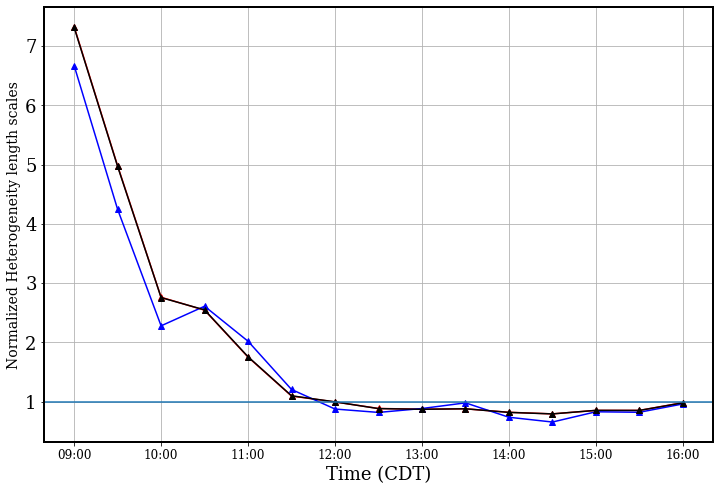

In [78]:
#length scales from flux/u*
time_stamp =  (surface_T_ds_iop02['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_x_scale_iop02 = np.asarray(T_length_x_scale_list)/zi_iop02
T_length_y_scale_iop02 = np.asarray(T_length_y_scale_list)/zi_iop02

q_length_x_scale_iop02 = np.asarray(q_length_x_scale_list)/zi_iop02
q_length_y_scale_iop02 = np.asarray(q_length_y_scale_list)/zi_iop02

Tv_length_x_scale_iop02 = np.asarray(Tv_length_x_scale_list)/zi_iop02
Tv_length_y_scale_iop02 = np.asarray(Tv_length_y_scale_list)/zi_iop02


fig, ax = plt.subplots(figsize=(12,8))

#ax.plot(time_stamp,T_length_x_scale_iop02,'-o',color='red')
ax.plot(time_stamp,T_length_y_scale_iop02,'-^',color='red')

#ax.plot(time_stamp,q_length_x_scale_iop02,'-o',color='blue')
ax.plot(time_stamp,q_length_y_scale_iop02,'-^',color='blue')

#ax.plot(time_stamp,Tv_length_x_scale_iop02,'-o',color='black')
ax.plot(time_stamp,Tv_length_y_scale_iop02,'-^',color='black')


ax.grid(True)
ax.set_ylabel('Normalized Heterogeneity length scales',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
plt.axhline(y=1)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

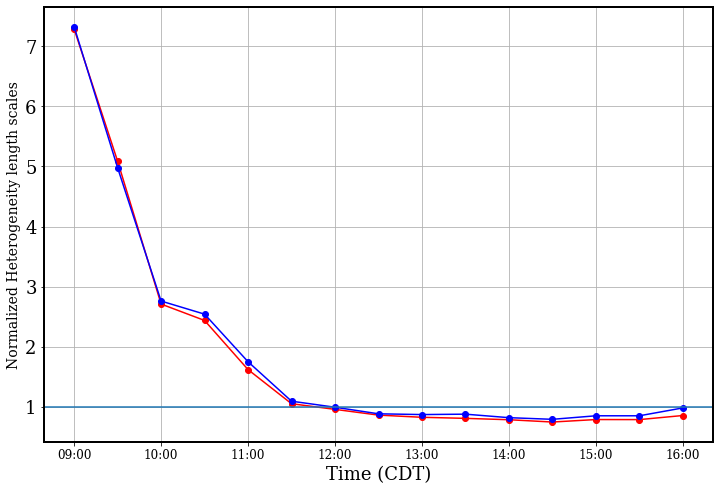

In [63]:
#length scales from flux/u*
time_stamp =  (surface_T_ds_iop02['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_x_scale_iop02 = np.asarray(T_length_x_scale_list)/zi_iop02
T_length_y_scale_iop02 = np.asarray(T_length_y_scale_list)/zi_iop02
#print(T_length_scale)

# q_length_scale_iop02 = np.asarray(q_length_scale_list/zi_theta)
# #print(q_length_scale)
# Tv_length_scale_iop02 = np.asarray(Tv_length_scale_list/zi_theta)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_x_scale_iop02,'-o',color='red')
ax.plot(time_stamp,T_length_y_scale_iop02,'-o',color='blue')
ax.grid(True)
ax.set_ylabel('Normalized Heterogeneity length scales',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
plt.axhline(y=1)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

The surface x and y scales are pretty close to each other. and I like the idea of calculating scales with > 2/3 variance. Sounds more appropriate.\\
Will continue to do it for q and theta_v(maybe just q)

In [127]:
zi_theta = zi_iop02
zi_theta

array([ 127.17374916,  186.31875251,  396.70267766,  489.81241256,
        774.62413901, 1191.6998708 , 1237.6693072 , 1401.17308978,
       1551.37994208, 1531.30430831, 1598.47618623, 1612.84239697,
       1616.62775674, 1625.69333036, 1626.38023613])

In [77]:
zi_theta = np.asarray([ 127.17374916,  186.31875251,  396.70267766,  489.81241256,
        774.62413901, 1191.6998708 , 1237.6693072 , 1401.17308978,
       1551.37994208, 1531.30430831, 1598.47618623, 1612.84239697,
       1616.62775674, 1625.69333036, 1626.38023613])

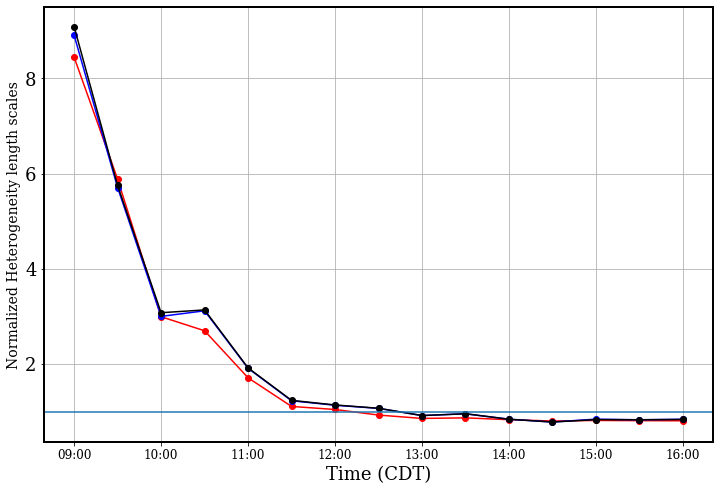

In [131]:
#length scales from flux/u*
time_stamp =  (dataset['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_scale_iop02 = np.asarray(T_length_scale_list/zi_theta)
#print(T_length_scale)

q_length_scale_iop02 = np.asarray(q_length_scale_list/zi_theta)
#print(q_length_scale)
Tv_length_scale_iop02 = np.asarray(Tv_length_scale_list/zi_theta)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_scale_iop02,'-o',color='red')
ax.plot(time_stamp,q_length_scale_iop02,'-o',color='blue')
ax.plot(time_stamp,Tv_length_scale_iop02,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Normalized Heterogeneity length scales',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
plt.axhline(y=1)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

L also keeps increasing from 0900 till 1100, maybe include that in the paper.

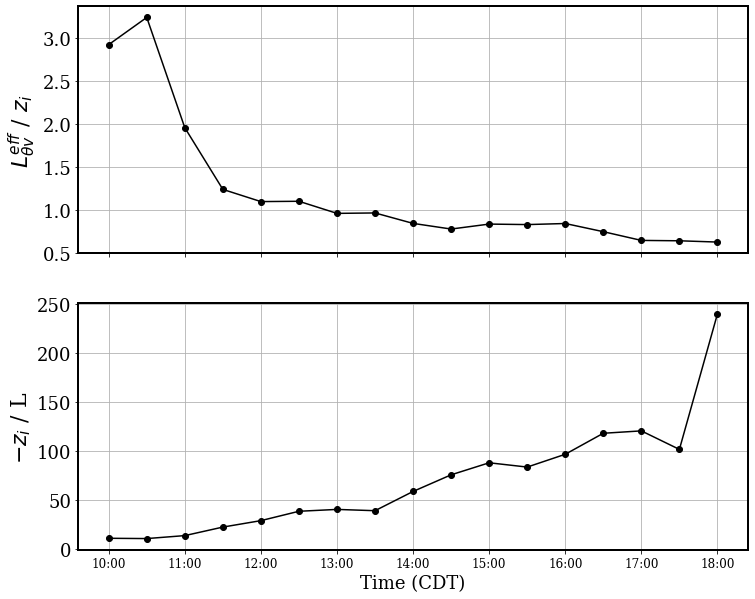

In [84]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10),sharex=True)

ax1.plot(time_stamp[8:],Tv_length_scale_iop02,'-o',color='black')
ax1.grid(True)
ax1.set_ylabel(r'$L^{eff}_{\theta v}$ / $z_{i}$',fontsize=22)
ax1.set_xlabel('')


ax2.set_ylabel(r'$-z_{i}$ / L ',fontsize=22)
ax2.plot(time_stamp[8:],zi_theta/obukhov_length_list,'-o',color='black')
ax2.grid(True)
ax2.set_xlabel('Time (CDT)')
tick_spacing = 2
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.tick_params(axis="x", labelsize=12)


I have to explain what is happeening in the evening. The ABL stability becomes more convective, ~ 100.

2D FFts:

##### check, trial code

[########################################] | 100% Completed | 101.65 ms
[########################################] | 100% Completed | 101.38 ms


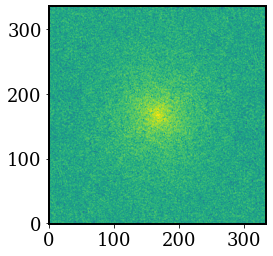

In [14]:
#take the fft!
var_data_sq = surface_T_ds_iop02[7].squeeze().values - surface_T_ds_iop02[7].squeeze().mean().values
#apply a hanning window
Nx = var_data_sq.shape[0]
Ny = var_data_sq.shape[1]        
var_windowed_data = var_data_sq * np.hanning(Nx)[:, np.newaxis] * np.hanning(Ny)

PS2D = fft.fftn(var_windowed_data)
plt.imshow(np.log(np.abs(fft.fftshift(PS2D))**2),origin='lower')


In [15]:
#check the same with a sine taper
def sine_taper(n):
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    return np.asarray(W)

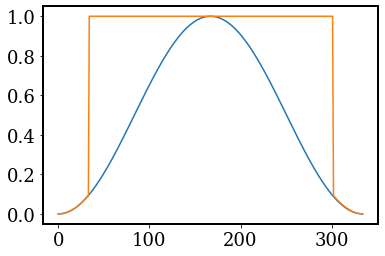

In [17]:
plt.plot(np.hanning(Nx))
plt.plot(sine_taper(Nx))


[########################################] | 100% Completed | 101.58 ms
[########################################] | 100% Completed | 101.32 ms


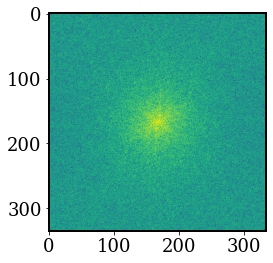

In [36]:

#take the fft!
var_data_sq = surface_T_ds_iop02[7].squeeze().values - surface_T_ds_iop02[7].squeeze().mean().values
#apply a hanning window
Nx = var_data_sq.shape[0]
Ny = var_data_sq.shape[1]        
var_windowed_data = var_data_sq*sine_taper(Nx)[:, np.newaxis]*sine_taper(Ny)

PS2D = fft.fftn(var_windowed_data)
plt.imshow(np.log(np.abs(fft.fftshift(PS2D))**2))#,origin='lower')



In [43]:
PSD1D.shape

(167,)

In [48]:

#take the fft!
var_data_sq = surface_T_ds_iop02[14].squeeze().values - surface_T_ds_iop02[14].squeeze().mean().values
#apply a hanning window
Nx = var_data_sq.shape[0]
Ny = var_data_sq.shape[1]        
var_windowed_data = var_data_sq*sine_taper(Nx)[:, np.newaxis]*sine_taper(Ny)

PS2D = fft.fftn(var_windowed_data)

#k53 = (spatial_freq**(-2/3))
PSD2D = np.abs(fft.fftshift(PS2D))**2
PSD1D = GetPSD1D(PSD2D)

spatial_freq = (fft.rfftfreq(335,30))[1:]
#335 is N, 30 = dx or dy, the resolution

#integrate the 1D power spectra from higher to lower frequencies
cumsum = np.cumsum(np.flip((PSD1D*np.diff(spatial_freq)[0])))
#find the 2/3rd variance value from the integral
critical_var = cumsum[-1]*2/3
print('critical_var: ' , critical_var)
#find the index of this critical variance
f_index = np.where(np.cumsum(cumsum > critical_var) == 1)
print('f_index: ' , f_index)
critical_wavelength = (1/np.flip(spatial_freq)[f_index])
print('critical_wavelength: ' , critical_wavelength)

[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 101.27 ms
critical_var:  717.2715921591679
f_index:  (array([163]),)
critical_wavelength:  [2512.5]


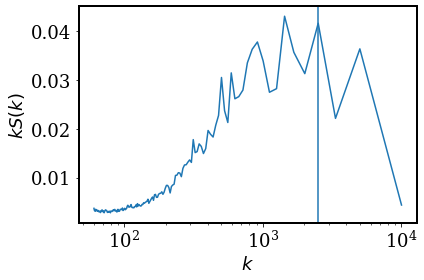

In [18]:
plt.figure(figsize=(6,4))
plt.semilogx(1/spatial_freq, spatial_freq*(PSD1D*np.diff(spatial_freq)[0]))

#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.axvline(x=1/np.flip(spatial_freq)[163])
plt.xlabel("$k$")
plt.ylabel("$kS(k)$")
plt.tight_layout()

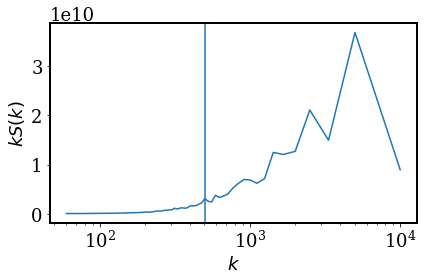

In [19]:
plt.figure(figsize=(6,4))
plt.semilogx(1/spatial_freq, 2*(PSD1D/np.diff(spatial_freq)[0]))

#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.axvline(x=1/np.flip(spatial_freq)[147])
plt.xlabel("$k$")
plt.ylabel("$kS(k)$")
plt.tight_layout()

/tmp/ipykernel_2448761/423986651.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(1/fs,S, color='C0', lw=1.3, label='Boxcar')


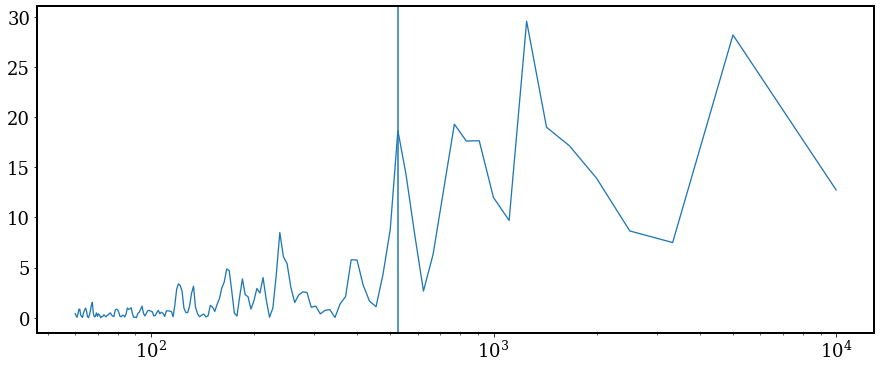

In [51]:
#python scipy implementation, calculate PSD
fs, S = signal.periodogram(Ty_bt[0:-2],fs=1/30,window='boxcar',nfft=None,return_onesided=True,scaling='density')
fig = plt.figure(figsize=(15,6))
plt.semilogx(1/fs,S, color='C0', lw=1.3, label='Boxcar')
plt.axvline(x=1/np.flip(fs)[147])


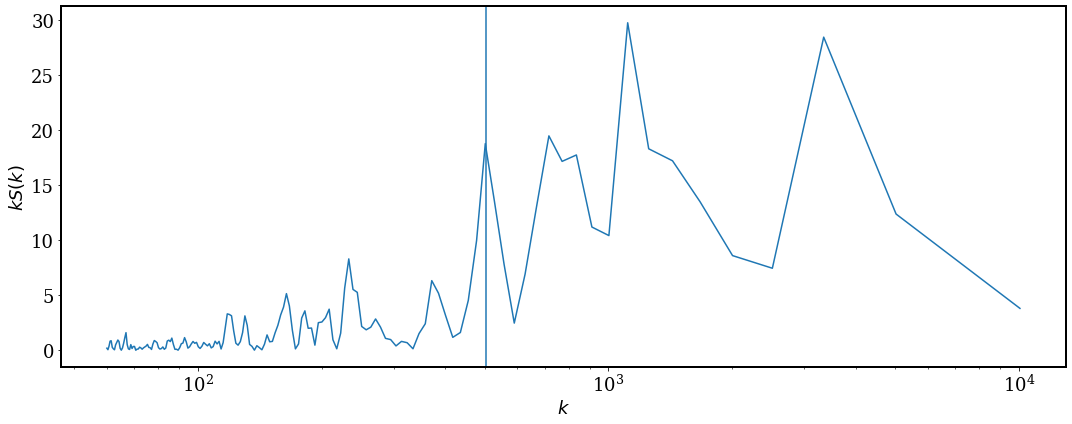

In [60]:
#numpy FFT implementations, calculate PSD
plt.figure(figsize=(15,6))
#plt.semilogx(1/k_y, 2*(Sy)/np.sqrt(165))
plt.semilogx(1/k_y, 2*(Sy)*30/(335))
#1/30 = sampling frequency and 335 = N
#taken from, https://dsp.stackexchange.com/questions/32187/what-should-be-the-correct-scaling-for-psd-calculation-using-tt-fft
#plt.loglog(1/spatial_freq, k53/np.sum(k53))
plt.axvline(x=1/np.flip(spatial_freq)[147])
plt.xlabel("$k$")
plt.ylabel("$kS(k)$")
plt.tight_layout()

In [54]:
print("1D signal var: ", np.var(Ty_bt))

1D signal var:  0.04599517378149292


In [59]:
print("summ of PSD, scipy ", np.sum(S*np.diff(fs)[0]))

summ of PSD, scipy  0.04627027761126969


In [61]:
print("summ of scaled FFT coeffcients, numpy ", np.sum(2*(Sy)*30/(335)*np.diff(k_y)[0]))

summ of scaled FFT coeffcients, numpy  0.04647267854565107


 ##### 

Spectral density = spectrum*k as a function of k or spectrum*fs as a function of fs. \
If I integrate spectral density, I should get variance..

I'll continue for now with the approach of summing up PSD1D and calculating the 2/3rd value for this. Calling that as a critical wavelength...\
That should be okay..

In [62]:
#check the same with a sine taper
def sine_taper(n):
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    return np.asarray(W)

In [72]:
#take the fft!
def calc_2D_spectra_scales(ds, time_array):
    length_scale_list = []
    for i, time_step in enumerate(time_array):
            var_data_sq = ds[i].squeeze().values - ds[i].squeeze().mean().values
            #apply a hanning window
            Nx = var_data_sq.shape[0]
            Ny = var_data_sq.shape[1]        
            var_windowed_data = var_data_sq*sine_taper(Nx)[:, np.newaxis]*sine_taper(Ny)

            PS2D = fft.fftn(var_windowed_data)

            #k53 = (spatial_freq**(-2/3))
            PSD2D = np.abs(fft.fftshift(PS2D))**2
            PSD1D = GetPSD1D(PSD2D)

            spatial_freq = (fft.rfftfreq(335,30))[1:]
            #335 is N, 30 = dx or dy, the resolution

            #integrate the 1D power spectra from higher to lower frequencies
            cumsum = np.cumsum(np.flip((PSD1D*np.diff(spatial_freq)[0])))
            #find the 2/3rd variance value from the integral
            critical_var = cumsum[-1]*2/3
            print(str(time_step))
            # print('critical_var: ' , critical_var)
            # #find the index of this critical variance
            # f_index = np.where(np.cumsum(cumsum > critical_var) == 1)
            # print('f_index: ' , f_index)
            # critical_wavelength = (1/np.flip(spatial_freq)[f_index])
            # print('critical_wavelength: ' , critical_wavelength)
            length_scale_list.append(critical_wavelength)
            
    return np.asarray(length_scale_list)

In [73]:
T_length_scale_iop02_2d = calc_2D_spectra_scales(surface_T_ds_iop02, IOP02_time_array)
q_length_scale_iop02_2d = calc_2D_spectra_scales(surface_q_ds_iop02, IOP02_time_array)
Tv_length_scale_iop02_2d = calc_2D_spectra_scales(surface_Tv_ds_iop02, IOP02_time_array)

[########################################] | 100% Completed | 101.45 ms
[########################################] | 100% Completed | 101.29 ms
2019-08-23T09:00:00.000000000
[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 101.35 ms
2019-08-23T09:30:00.000000000
[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 101.32 ms
2019-08-23T10:00:00.000000000
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 101.33 ms
2019-08-23T10:30:00.000000000
[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 101.29 ms
2019-08-23T11:00:00.000000000
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Complete

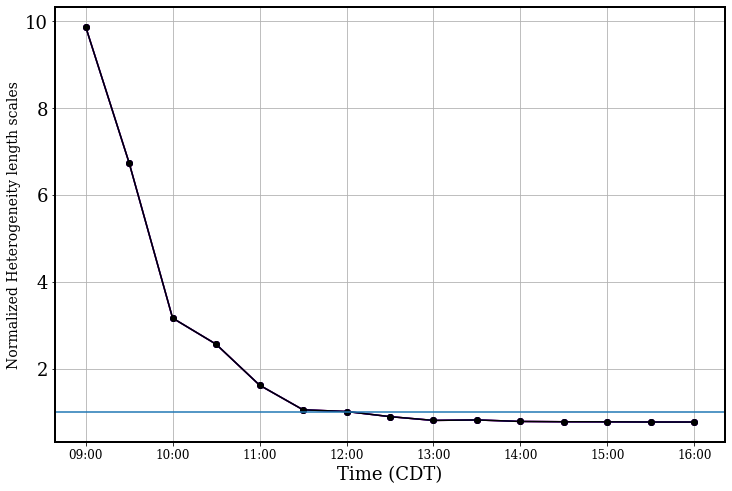

In [84]:
#length scales from flux/u*
time_stamp =  (dataset['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_scale_iop02 = (T_length_scale_iop02_2d/zi_theta[:, np.newaxis])
#print(T_length_scale)

q_length_scale_iop02 = (q_length_scale_iop02_2d/zi_theta[:, np.newaxis])
#print(q_length_scale)
Tv_length_scale_iop02 = (Tv_length_scale_iop02_2d/zi_theta[:, np.newaxis])

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_scale_iop02/2,'-o',color='red')
ax.plot(time_stamp,q_length_scale_iop02/2,'-o',color='blue')
ax.plot(time_stamp,Tv_length_scale_iop02/2,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Normalized Heterogeneity length scales',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
plt.axhline(y=1)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

This is the same as before, for 1D spectra, where we looked at the half-wavelength.

##### Repeat the same for IOP03

In [88]:
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')
profile_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03')
ensemble_member_surf_ds_2_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.31867226399481297 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.45090822130441666 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2710040286183357 seconds


In [89]:
#subset it for the 10x10 smaller domain 
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168

#ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))
ds_het_iop03 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_iop03 = ensemble_member_ds_2_N02_iop03.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_surf_iop03 = ensemble_member_surf_ds_2_iop03.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

def adjust_axis(ds):    
    ds['x'] = ds.x - ds.x[0]
    ds['y'] = ds.y - ds.y[0]
    ds['xu'] = ds.xu - ds.xu[0]
    ds['yv'] = ds.yv - ds.yv[0]
    
    
    return (ds)

ds_het_iop03 = adjust_axis(ds_het_iop03)
ds_2_het_iop03 = adjust_axis(ds_2_het_iop03)
ds_2_het_surf_iop03 = adjust_axis(ds_2_het_surf_iop03)




##### Have a look at the surface flux distributon

[########################################] | 100% Completed | 303.76 ms
[########################################] | 100% Completed | 201.85 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 101.25 ms


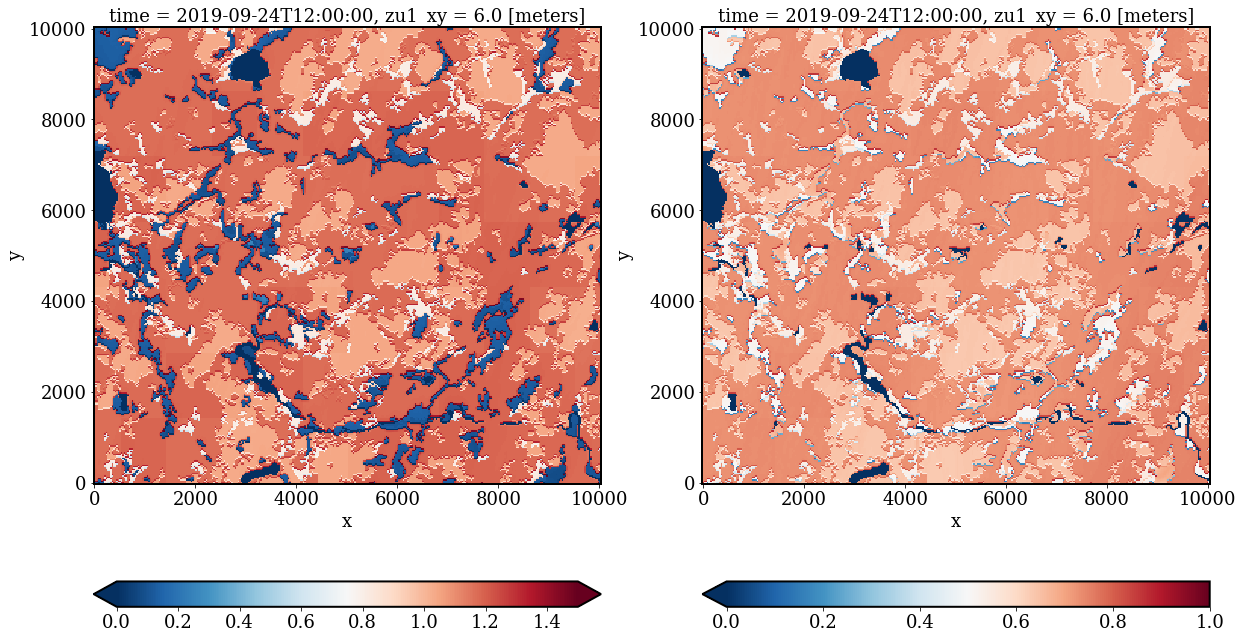

In [99]:
H_PCM = (ds_2_het_iop03.pcm_heatrate.sel(time='2019-09-24T12:00:00.000000000').sum('zpc_3d')*1.17*1005*12)
LE_PCM = (ds_2_het_iop03.pcm_latentrate.sel(time='2019-09-24T12:00:00.000000000').sum('zpc_3d')*1.17*1005*12)

H_surf = ds_2_het_surf_iop03['shf*_xy'].sel(time='2019-09-24T12:00:00.000000000')
LE_surf = ds_2_het_surf_iop03['qsws*_xy'].sel(time='2019-09-24T12:00:00.000000000')

domain_mean_LE = (LE_surf + LE_PCM).mean('x').mean('y').compute()
domain_mean_H = (H_surf + H_PCM).mean('x').mean('y').compute()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))

((H_surf + H_PCM)/domain_mean_H).plot(ax=ax1,cmap='RdBu_r', vmin=0,vmax = 1.5,cbar_kwargs={'location':'bottom'})

((LE_surf + LE_PCM)/domain_mean_H).plot(ax=ax2,cmap='RdBu_r',vmin=0,vmax = 1,cbar_kwargs={'location':'bottom'})




##### continue

In [90]:
IOP03_time_array = ensemble_member_ds_2_N02_iop03.time.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:00.000000000')).values


In [93]:
IOP03_time_array = np.asarray(['2019-09-24T09:00:00.000000000', '2019-09-24T09:30:00.000000000',
       '2019-09-24T10:00:00.000000000', '2019-09-24T10:30:00.000000000',
       '2019-09-24T11:00:00.000000000', '2019-09-24T11:30:00.000000000',
       '2019-09-24T12:00:00.000000000', '2019-09-24T12:30:00.000000000',
       '2019-09-24T13:00:00.000000000', '2019-09-24T13:30:00.000000000',
       '2019-09-24T14:00:00.000000000', '2019-09-24T14:30:00.000000000'],
      dtype='datetime64[ns]')

In [94]:


zi_theta_av_list = []

vertical_slice =  [200,300,300,400,
                   500,600,800,800,
                   900,1000,1100,1100]    

for i, time_step in enumerate(IOP03_time_array):
    theta_v = ds_2_het_iop03.theta.sel(time = time_step)*(1 + 0.61*ds_2_het_iop03.q.sel(time = time_step))
    zi_xy_av = (theta_v.sel(zu_3d=slice(40,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)

zi_theta_iop03 = xr.concat(zi_theta_av_list,'time')


[########################################] | 100% Completed | 303.77 ms
[########################################] | 100% Completed | 303.04 ms
[########################################] | 100% Completed | 303.41 ms
[########################################] | 100% Completed | 302.85 ms
[########################################] | 100% Completed | 303.22 ms
[########################################] | 100% Completed | 303.09 ms
[########################################] | 100% Completed | 303.52 ms
[########################################] | 100% Completed | 403.93 ms
[########################################] | 100% Completed | 403.80 ms
[########################################] | 100% Completed | 403.79 ms
[########################################] | 100% Completed | 403.65 ms
[########################################] | 100% Completed | 403.56 ms


In [98]:
zi_theta_iop03 = np.asarray([  89.55689018,  146.17518378,  222.75052796,  318.65739363,
        391.70175986,  465.53290265,  578.09552239,  665.90258855,
        747.14683894,  854.98633994,  961.446683  , 1046.67977723])

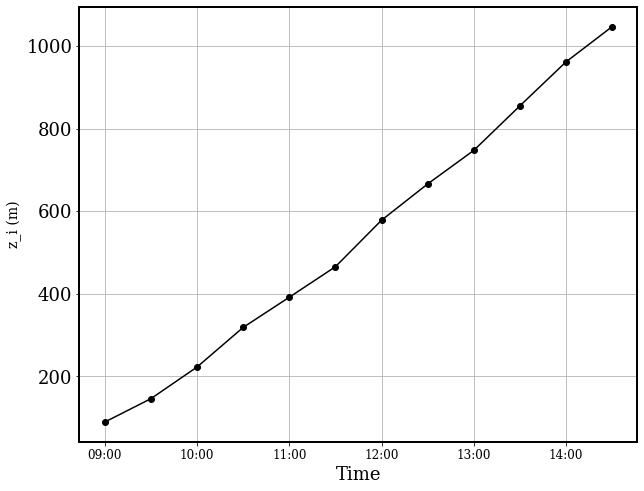

In [136]:

time_stamp =  (ds_2_het_iop03.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:00.000000000')).time.dt.strftime('%H:%M'))

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp,zi_theta_iop03.values,'-o',color='black')
ax1.grid(True)
ax1.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
ax1.grid(True)
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.45445921272039413 seconds
[########################################] | 100% Completed | 206.56 ms


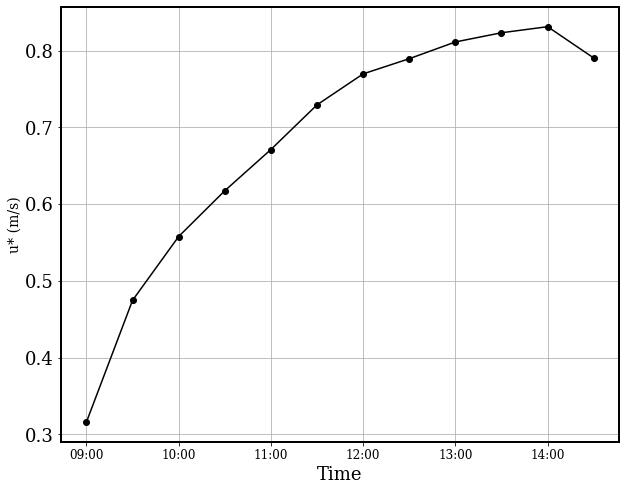

In [138]:
#ustar calculations

#IOP02
#profile_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02').sel(time=slice('2019-08-23T10:00:01.200000000','2019-08-23T18:00:01.200000000')).resample(time='30T').mean()

#IOP03
profile_N02_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03').sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:01.200000000')).resample(time='30T').mean()

#above canopy momentum fluxes
w_av = profile_N02_member_2_ds_iop03.w.sel(zw=36)#[1:]

wu_av = profile_N02_member_2_ds_iop03.wu.sel(zwu=36)#[1:]
u_av = profile_N02_member_2_ds_iop03.u.rename({'zu': 'zw'}).interp_like(profile_N02_member_2_ds_iop03.w).sel(zw=36)#[1:]
uprime_wprime = wu_av - w_av*u_av

wv_av = profile_N02_member_2_ds_iop03.wv.sel(zwv=36)#[1:]
v_av = profile_N02_member_2_ds_iop03.v.rename({'zv': 'zw'}).interp_like(profile_N02_member_2_ds_iop03.w).sel(zw=36)#[1:]
vprime_wprime = wv_av - w_av*v_av

time_stamp =  (wu_av['time'].dt.strftime('%H:%M'))

#above canopy u*
u_star = (uprime_wprime**2 + vprime_wprime**2)**(0.25)

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,u_star,'-o',color='black')
#ax1.axvline(x='13:00')
ax1.set_ylabel('u* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)


In [99]:
rows, cols = (8,12)
u_star_list_iop03 = [[0]*cols]*rows

for member in np.arange(0,8):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:01.200000000'))
    ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
    u_star_list_iop03[member] = u_star_list(ds,IOP03_time_array)


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  0.7916563246399164 seconds
[########################################] | 100% Completed | 102.78 ms
[########################################] | 100% Completed | 102.17 ms
[########################################] | 100% Completed | 102.04 ms
[########################################] | 100% Completed | 102.18 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 102.12 ms
[########################################] | 100% Completed | 102.14 ms
[###########

[########################################] | 100% Completed | 206.42 ms


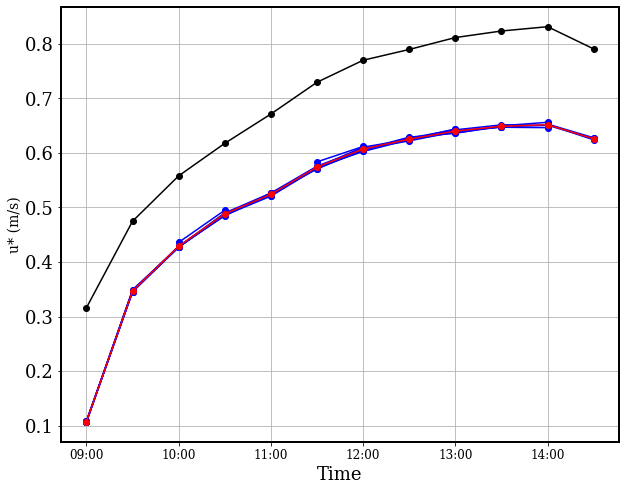

In [142]:

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,u_star,'-o',color='black')
for i in np.arange(0,8):
    ax1.plot(time_stamp,u_star_list_iop03[i],'-o',color='blue')
ax1.plot(time_stamp,np.nanmean(u_star_list_iop03,0),'-o',color='red')


#ax1.axvline(x='13:00')
ax1.set_ylabel('u* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [100]:
u_star_array_iop03 = np.nanmean(u_star_list_iop03,0)


In [102]:
u_star_array_iop03 = np.asarray([0.10734038, 0.346752  , 0.42885262, 0.4882605 , 0.5238576 ,
       0.573982  , 0.60698235, 0.6250409 , 0.63989866, 0.6486785 ,
       0.651481  , 0.62593067], dtype='float32')

In [103]:
time_list = ds_het_iop03.time.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:00.000000000'))

surface_T_list = []
surface_q_list = []
surface_Tv_list = []

for i, time_step in enumerate(time_list):

    #PCM fluxes in the domains

    N02_H_PCM = (ds_2_het_iop03.pcm_heatrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)

    N02_LE_PCM = (ds_2_het_iop03.pcm_latentrate.sel(time=time_step).sum('zpc_3d')*1.17*1005*12)


    ###---------------------------------------------------
    #surface fluxes in the domains
    N02_H_surf = ds_2_het_surf_iop03['shf*_xy'].sel(time=time_step)

    N02_LE_surf = ds_2_het_surf_iop03['qsws*_xy'].sel(time=time_step)

    ###---------------------------------------------------
    
    N02_net_H_kinematic = (N02_H_surf+N02_H_PCM)/(1.17*1005)
    N02_net_LE_kinematic = (N02_LE_surf+N02_LE_PCM)/(1.17*2501*1000)
    theta = ds_2_het_iop03.sel(time=time_step).theta.sel(zu_3d = 30)
    N02_buoyancy_flux = N02_net_H_kinematic + theta*0.61*N02_net_LE_kinematic
    
    surface_T = N02_net_H_kinematic/u_star_array_iop03[i]
    surface_q = N02_net_LE_kinematic/u_star_array_iop03[i]
    surface_Tv = N02_buoyancy_flux/u_star_array_iop03[i] 

    # surface_T = N02_net_H_kinematic/w_star_array[i]
    # surface_q = N02_net_LE_kinematic/w_star_array[i]

    surface_T_list.append(surface_T)
    surface_q_list.append(surface_q)
    surface_Tv_list.append(surface_Tv)

surface_T_ds_iop03 =  xr.concat(surface_T_list,dim='time')
surface_q_ds_iop03 =  xr.concat(surface_q_list,dim='time')
surface_Tv_ds_iop03 =  xr.concat(surface_Tv_list,dim='time')


##### 1D FFT

In [149]:

dataset = surface_Tv_ds_iop03
length_scale_list = []

for i, time_step in enumerate(dataset.time.values):
    
    T_surf = dataset.isel(time=i).values[0]
    x = dataset.isel(time=i).x.values
    y = dataset.isel(time=i).y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    # yloc = int(len(x)/2)
    # xloc = int(len(y)/2)
    # find 10 evenly spaced transects along each direction
    # ylocs = np.round(np.arange(5,Nx,Nx/10),0).astype(int)
    # xlocs = np.round(np.arange(5,Ny,Ny/10),0).astype(int)
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)


    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        Ty = T_surf[:,xloc]-T_surf[:,xloc].mean()
        Tx = T_surf[yloc,:]-T_surf[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        Tx_bt = belltaper(Tx,Nx)     
        Ty_bt = belltaper(Ty,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(Tx_bt)**2)[:int(Nx/2)])
        Sy = (np.abs(fftpack.fft(Ty_bt)**2)[:int(Ny/2)])           
        # extracting wavelength of spectrum maximum
        k_x_max = k_x[np.where(Sx == Sx.max())][0]
        k_y_max = k_y[np.where(Sy == Sy.max())][0]

        # determining l_x by simply converting 1/m to m
        lx.append(1/k_x_max)
        ly.append(1/k_y_max)
    l_x = np.mean(lx)
    l_y = np.mean(ly)   

    # heterogeneity scale is 1/2 l, average over x- and y-direction
    if (0.5*l_x + 0.5*l_y)/2 > 100000:
        length_scale_list.append(np.nan) # nan 
    else:
        length_scale_list.append((0.5*l_x + 0.5*l_y)*0.5) 

[########################################] | 100% Completed | 101.49 ms
[########################################] | 100% Completed | 101.39 ms
[########################################] | 100% Completed | 101.38 ms
[########################################] | 100% Completed | 101.39 ms
[########################################] | 100% Completed | 101.32 ms
[########################################] | 100% Completed | 101.36 ms
[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 101.40 ms
[########################################] | 100% Completed | 101.38 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 101.37 ms
[########################################] | 100% Completed | 101.42 ms


In [150]:
#T_length_scale_list_iop03 = length_scale_list
#q_length_scale_list_iop03 = length_scale_list
Tv_length_scale_list_iop03 = length_scale_list

In [151]:
print(np.round(T_length_scale_list_iop03,2))
print(np.round(q_length_scale_list_iop03,2))
print(np.round(Tv_length_scale_list_iop03,2))

[ 522.53 1149.54 1112.21 1120.17 1112.33 1211.46 1210.45 1219.59 1227.62
 1231.27 1222.32 1229.74]
[ 728.16 1126.95 1140.13 1161.66 1173.65 1313.77 1316.35 1303.35 1310.55
 1300.56 1294.07 1305.78]
[ 522.03 1142.45 1116.68 1122.87 1111.17 1216.23 1214.38 1215.8  1220.51
 1227.05 1211.58 1221.14]


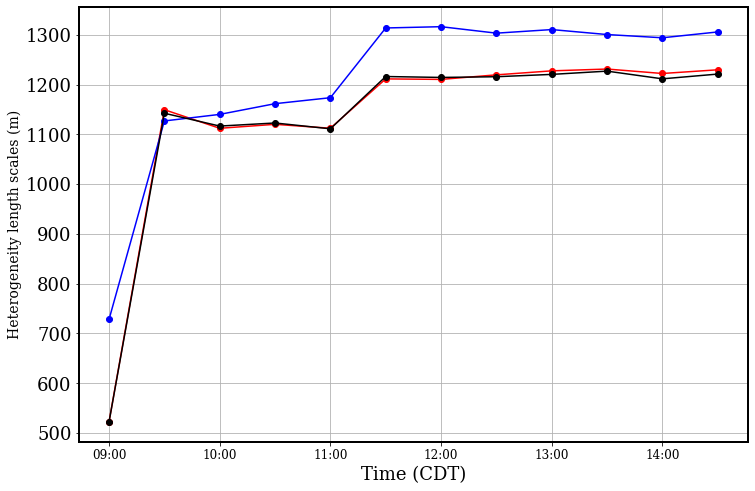

In [152]:
time_stamp =  (dataset['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_scale_iop03 = np.asarray(T_length_scale_list_iop03)
# T_length_scale_iop02 = np.asarray([1187.44, 1321.5,  1324.46, 1320.26, 1291.61, 1298.5,  1327.91, 1328.33, 1326.18,
#                          1292.47, 1314.82, 1314.98, 1310.84, 1252.01, 1172.2,  1109.67, 1142.13])

q_length_scale_iop03 = np.asarray(q_length_scale_list_iop03)
# q_length_scale_iop03 = np.asarray([1190.26, 1526.97, 1479.63, 1462.47, 1401.78, 1495.66, 1421.29, 1460.09, 1341.56,
#                          1258.26, 1359.46, 1343.75, 1364.16, 1265.9,  1088.61, 1075.21, 1058.07])

Tv_length_scale_iop03 = np.asarray(Tv_length_scale_list_iop03)
# Tv_length_scale_iop02 = np.asarray([1209.71, 1535.09, 1489.43, 1476.45, 1411.9,  1495.74, 1418.69, 1460.74, 1346.57,
#                          1260.03, 1343.87, 1344.41, 1354.62, 1263.58, 1091.1,  1083.56, 1058.45])


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_scale_iop03,'-o',color='red')
ax.plot(time_stamp,q_length_scale_iop03,'-o',color='blue')
ax.plot(time_stamp,Tv_length_scale_iop03,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Heterogeneity length scales (m)',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")


In [153]:
zi_theta_iop03 

<xarray.DataArray 'zu_3d' (time: 12)>
array([  89.55689018,  146.17518378,  222.75052796,  318.65739363,
        391.70175986,  465.53290265,  578.09552239,  665.90258855,
        747.14683894,  854.98633994,  961.446683  , 1046.67977723])
Coordinates:
  * time     (time) datetime64[ns] 2019-09-24T09:00:00 ... 2019-09-24T14:30:00

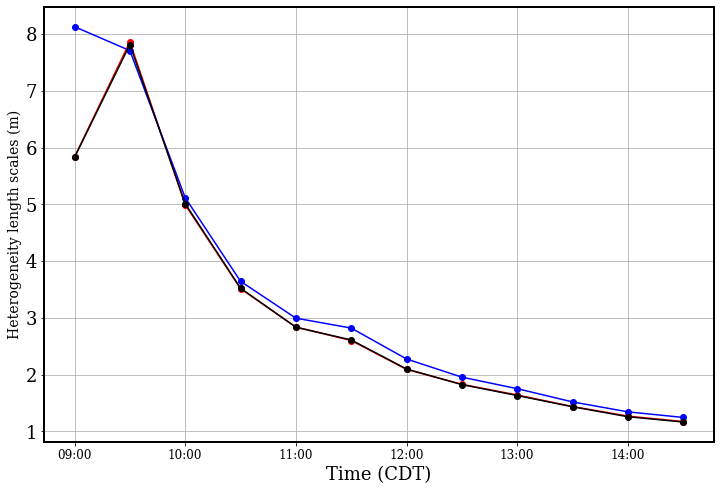

In [154]:
time_stamp =  (dataset['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_scale_iop03 = np.asarray(T_length_scale_list_iop03/zi_theta_iop03.values)

q_length_scale_iop03 = np.asarray(q_length_scale_list_iop03/zi_theta_iop03.values)

Tv_length_scale_iop03 = np.asarray(Tv_length_scale_list_iop03/zi_theta_iop03.values)


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_scale_iop03,'-o',color='red')
ax.plot(time_stamp,q_length_scale_iop03,'-o',color='blue')
ax.plot(time_stamp,Tv_length_scale_iop03,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Heterogeneity length scales (m)',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")


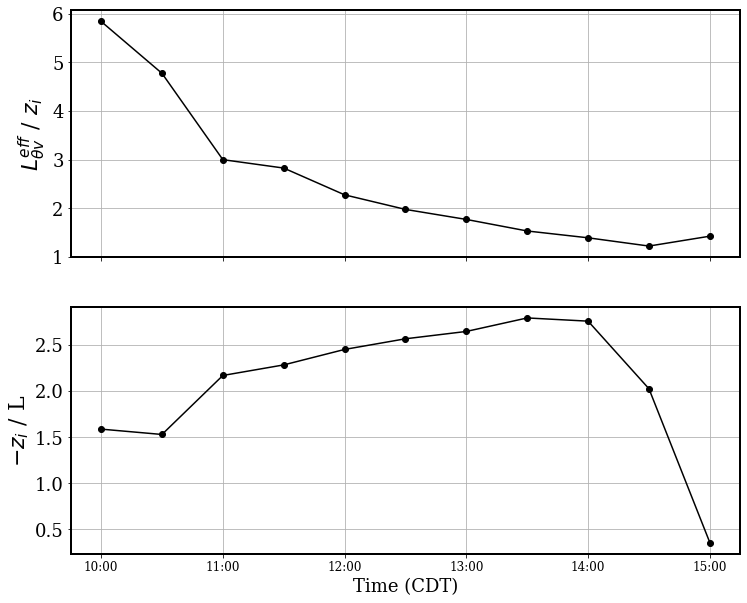

In [171]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10),sharex=True)

ax1.plot(time_stamp[8:],Tv_length_scale_iop03,'-o',color='black')
ax1.grid(True)
ax1.set_ylabel(r'$L^{eff}_{\theta v}$ / $z_{i}$',fontsize=22)
ax1.set_xlabel('')


ax2.set_ylabel(r'$-z_{i}$ / L ',fontsize=22)
ax2.plot(time_stamp[8:],zi_theta_iop03/obukhov_length_list_iop03,'-o',color='black')
ax2.grid(True)
ax2.set_xlabel('Time (CDT)')
tick_spacing = 2
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.tick_params(axis="x", labelsize=12)


##### 2D FFT

In [104]:
T_length_scale_iop03_2d = calc_2D_spectra_scales(surface_T_ds_iop03, IOP03_time_array)
q_length_scale_iop03_2d = calc_2D_spectra_scales(surface_q_ds_iop03, IOP03_time_array)
Tv_length_scale_iop03_2d = calc_2D_spectra_scales(surface_Tv_ds_iop03, IOP03_time_array)

[########################################] | 100% Completed | 101.46 ms
[########################################] | 100% Completed | 101.11 ms
2019-09-24T09:00:00.000000000
[########################################] | 100% Completed | 101.22 ms
[########################################] | 100% Completed | 101.38 ms
2019-09-24T09:30:00.000000000
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 101.28 ms
2019-09-24T10:00:00.000000000
[########################################] | 100% Completed | 101.22 ms
[########################################] | 100% Completed | 101.28 ms
2019-09-24T10:30:00.000000000
[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 101.08 ms
2019-09-24T11:00:00.000000000
[########################################] | 100% Completed | 101.20 ms
[########################################] | 100% Complete

In [105]:
zi_theta = zi_theta_iop03

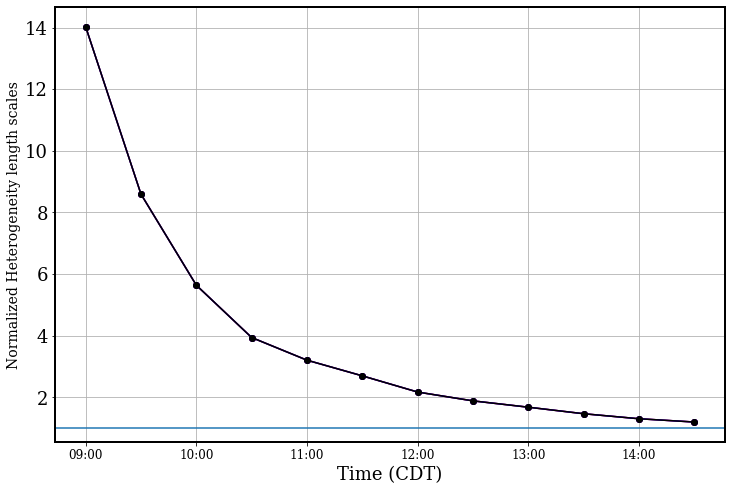

In [106]:
#length scales from flux/u*
time_stamp =  (surface_T_ds_iop03['time'].dt.strftime('%H:%M'))
#print(time_stamp)

T_length_scale_iop03 = (T_length_scale_iop03_2d/zi_theta[:, np.newaxis])
#print(T_length_scale)

q_length_scale_iop03 = (q_length_scale_iop03_2d/zi_theta[:, np.newaxis])
#print(q_length_scale)
Tv_length_scale_iop03 = (Tv_length_scale_iop03_2d/zi_theta[:, np.newaxis])

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp,T_length_scale_iop03/2,'-o',color='red')
ax.plot(time_stamp,q_length_scale_iop03/2,'-o',color='blue')
ax.plot(time_stamp,Tv_length_scale_iop03/2,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Normalized Heterogeneity length scales',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)
plt.axhline(y=1)
#plt.axvline(x='13:00')
# output_fname = 'work/scale_analysis/plots/length_scales/iop02_0823.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")

##### lengthscale/zi for both IOPs

In [107]:
time_stamp_iop02 =  (surface_T_ds_iop02['time'].dt.strftime('%H:%M'))
time_stamp_iop03 =  (surface_T_ds_iop03['time'].dt.strftime('%H:%M'))
#print(time_stamp)


# Tv_length_scale_iop03 = (Tv_length_scale_iop03_2d/zi_theta[:, np.newaxis])


In [112]:
time_stamp_iop02 = np.asarray(['09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00',
       '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30',
       '16:00'], dtype='object')
time_stamp_iop03 = np.asarray(['09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00',
       '12:30', '13:00', '13:30', '14:00', '14:30'], dtype='object')

In [118]:
Tv_length_scale_iop02 = np.asarray([[19.75643572],
       [13.48495504],
       [ 6.33345864],
       [ 5.12951476],
       [ 3.24350853],
       [ 2.10833286],
       [ 2.03002529],
       [ 1.79314035],
       [ 1.6195259 ],
       [ 1.64075813],
       [ 1.57180947],
       [ 1.55780875],
       [ 1.55416112],
       [ 1.54549444],
       [ 1.54484169]])
Tv_length_scale_iop03 = np.asarray([[28.05479282],
       [17.18828008],
       [11.27943455],
       [ 7.88464367],
       [ 6.4143189 ],
       [ 5.39704065],
       [ 4.34616755],
       [ 3.77307439],
       [ 3.36279279],
       [ 2.93864344],
       [ 2.61324943],
       [ 2.40044764]])

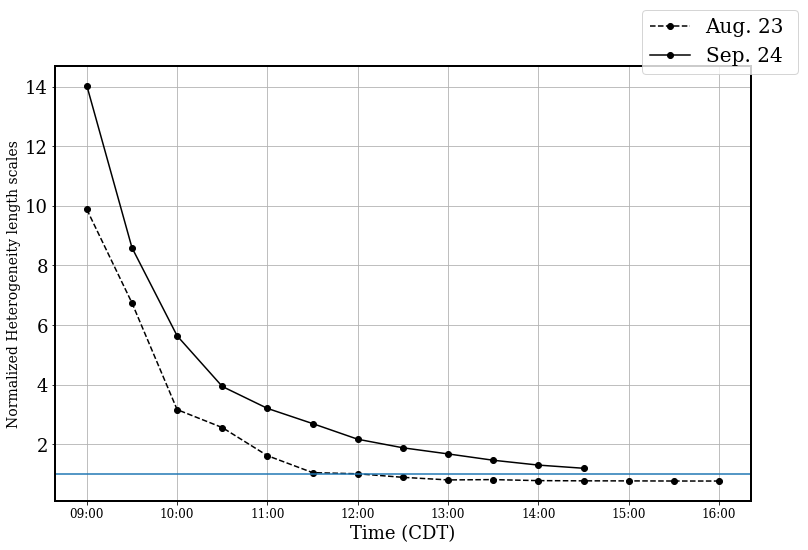

In [122]:
#length scales from flux/u*

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(time_stamp_iop02,Tv_length_scale_iop02/2,'--o',color='black')
ax.plot(time_stamp_iop03,Tv_length_scale_iop03/2,'-o',color='black')
ax.grid(True)
ax.set_ylabel('Normalized Heterogeneity length scales',fontsize=14)
ax.set_xlabel('Time (CDT)')
tick_spacing = 2
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis="x", labelsize=12)

fig.legend(['Aug. 23 ','Sep. 24 '],fontsize=20)
fig.subplots_adjust(right=0.93)

plt.axhline(y=1)